<a href="https://colab.research.google.com/github/sofiaalvarezlopez/Descriptor-de-alrededores-para-individuos-con-discapacidad-visual/blob/main/Proyecto_DAIDIDV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descriptor de alrededores a partir de im ́agenesdigitales para individuos con discapacidad visual

Esta  investigación  se pretende  disenar  e  implementar  una  herramienta capaz de describir en inglés lo que ocurre en una imagen  tomada  por  un  usuario  ciego  o  con  dificultades  de vision,  con  el  fin  de  brindar  informacíon  sobre  lo  que  está ocurriendo  en  sus  alrededores,  que  puede  serle  de  utilidad para decidir su siguiente paso. 

**Integrantes**
- Sofía Álvarez
- María Ocampo
- Juan Orjuela
- Leidy Romero

## 0. Instalar librerías

In [ ]:
!pip install gtts

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
import glob
import time
import tensorflow as tf
import keras
from collections import Counter
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import Audio 
import nltk
nltk.download('stopwords')
from PIL import Image
from gtts import gTTS

from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import Input, layers
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1. Carga y entendimiento de los datos
Se decide utilizar el dataset Flickr 8k ([fuente](https://www.kaggle.com/adityajn105/flickr8k?select=captions.txt)), que cuenta con alrededor de 8000 imágenes cada una con 5 descripciones en inglés. El dataset cuenta con una carpeta con la imágenes (`Images`) y un archivo de texto con las descripciones (`captions.txt`). 

Como un primer paso se descomprime el archivo del conjunto de datos y se cargan las rutas de imágenes y captions en dos variables separadas.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML-202120/Proyecto')
os.listdir("./")

Mounted at /content/drive


['Proyecto -DAIDIDV.ipynb',
 'Fase 2 Grupo 7.gdoc',
 'Fase 1 Grupo 7.gdoc',
 'archive.zip',
 'Images',
 'captions.txt',
 'checkpoints',
 'Image_to_text_and_to_speech.ipynb',
 'flagged',
 'text_to_speech.mp3']

In [ ]:
#!unzip archive.zip

In [ ]:
IMG_PATH = './Images'
CAP_PATH = './captions.txt'

captions = open(CAP_PATH, 'r').readlines()
images = glob.glob(IMG_PATH + '/*.jpg',recursive=True)

print('Total de imágenes:', len(images))
print('Total de descripciones:', len(captions))

Total de imágenes: 8091
Total de descripciones: 40456


In [ ]:
# Se generan tuplas por cada descripción: el primer elemeto es el nombre de la imagen y el segundo la descripción 
captions = [(c.replace('\n', '').split(',')[0], c.replace('\n', '').split(',')[1]) for c in captions]

Ahora se genera un dataframe, con las rutas de las imágenes y los captions


In [ ]:
df = pd.DataFrame(list(zip([c[0] for c in captions[1:]], [ IMG_PATH+'/'+c[0] for c in captions[1:]], [c[1] for c in captions[1:]])),columns = ['ID','Path','Caption'])
df.head()

,ID,Path,Caption
0,1000268201_693b08cb0e.jpg,./Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,./Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,./Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,./Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,./Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Ahora visualicemos algunas imágenes junto a sus captions.

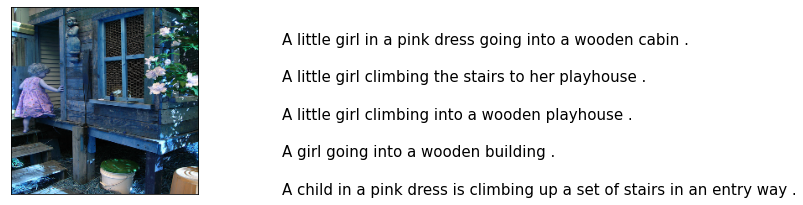

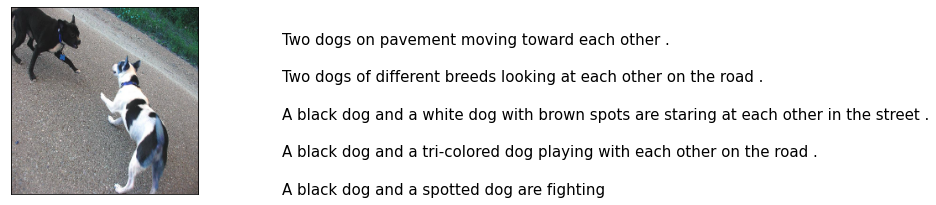

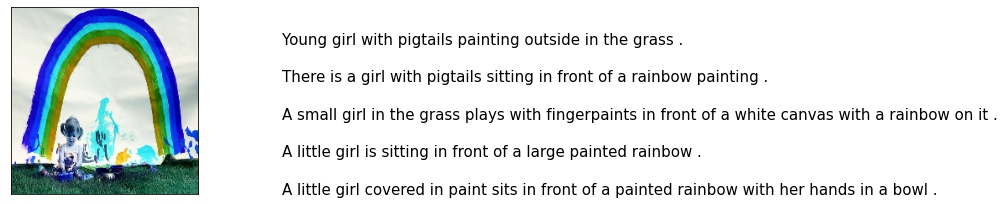

In [ ]:
img_path=list(set(df.Path[:15]))   # Cada imagen tiene 5 captions. 15/5 = 3 imágenes
count = 1

for path in img_path:
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
      
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(5,2,count,xticks=[],yticks=[])
    ax.imshow(img)

    count += 1
      
    ax = fig.add_subplot(5,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,5)
    
    img_cap=df.loc[df['Path'] == path, 'Caption']
    
    for i in range(len(img_cap)):
        ax.text(0,i,img_cap.iloc[i],fontsize=15)
    count += 1

plt.show()

Ahora observemos la distribusción de las palabras de los captions

Text(0.5, 1.0, 'Top 30 palabras más frecuentes')

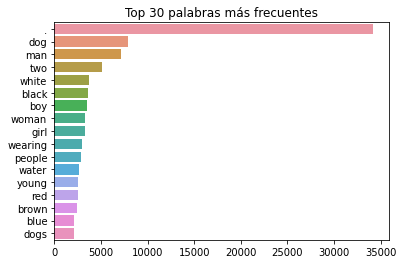

In [ ]:
# Generar diccionario con el vocabulario y el número de ocurrencias de cada palabra
voc=[]
for sent in df['Caption']:
    for word in sent.lower().split():
        voc.append(word)
        
voc_count = Counter(voc)

# Visualizar las 30 palabras más comunes
sort_lst = voc_count.most_common(30)
stop=set(stopwords.words('english'))
x, y=[], []

for word,count in sort_lst:
    if (word.lower() not in stop):
        x.append(word)
        y.append(count)
            
sns.barplot(x=y,y=x).set_title('Top 30 palabras más frecuentes')

## 2. Procesamiento de datos

Se debe procesar tanto los captions como la imágenes, en el caso de los captions es necesario realizar un proceso de tokenización y padding. A las imágenes se les debe hacer resize y normalizar.

### 2.1 Captions

1. Añadir tokens de inicio (`<start>`) y fin (`<end>`)
2. Tokenizar, al mismo tiempo se remueven los signos de puntuación
3. Padding, para que todas secuencias sean del mismo tamaño

In [ ]:
# Lista de captions con tokens de inicio y fin
annotations = ['<start>'+ i + '<end>' for i in df.Caption]
print('Caption después de añadir los tokens de inicio y fin:',annotations[:1])

# Lista con todas las rutas de las imágenes
all_img_path = [i for i in df.Path]
      
print("Total de captions present:", str(len(annotations)))
print("Total de imágenes:", str(len(all_img_path)))

Caption después de añadir los tokens de inicio y fin: ['<start>A child in a pink dress is climbing up a set of stairs in an entry way .<end>']
Total de captions present: 40455
Total de imágenes: 40455


In [ ]:
# Tokenizador
num_words = 5000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token="<unk>", filters='!"#$%&()*+.-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)


# Crear los diccionarios de palabra-índice e índice-palabra
word_index = tokenizer.word_index   
index_word = tokenizer.index_word

train_seqs = tokenizer.texts_to_sequences(annotations)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

print('Caption: \n', annotations[1])
print('Secuencia de entrenamiento: \n', train_seqs[1])

Caption: 
 <start>A girl going into a wooden building .<end>
Secuencia de entrenamiento: 
 [4, 19, 315, 65, 2, 198, 125, 3]


In [ ]:
# Encontrar la longitud máxima de un caption
max_length = max([len(x) for x in train_seqs])
print("Longitud máxima de captions:", max_length)

# Aplicar zero padding a todos los captions hasta que su longitud sea igual a la máxima
cap_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)

print("Secuencia con padding:\n", cap_vector[1])

print("Dimensión de vector de captions :", str(cap_vector.shape))

Longitud máxima de captions: 34
Secuencia con padding:
 [  4  19 315  65   2 198 125   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Dimensión de vector de captions : (40455, 34)


### 2.2 Imágenes

1. Cambiar el tamaño a (299, 299)
2. Normalizar los valores entre [-1, 1] pues este es el formato correcto para Inception V3.

In [ ]:
#Preprocess images
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img) # normalización, función de librería Inception
    return img, image_path

#### Cargar pesos pre-entrandos de Imagenet de Inception Net V3
Se va a utilizar la última capa de esta red para extraer las características de las imágenes, esto con el fin de evitar el alto uso de memoria que se genería al añadir esto en el proceso de entrenamiento.

La salida de esta capa tiene dimensión 8x8x2048, en otras palabras, 2048 mapas de características de dimensiones 8x8.

In [ ]:
# Inicializar el modelo y cargar los pesos pre-entrenados
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input # capa de entrada
hidden_layer = image_model.layers[-1].output # capa de salida

# Modelo
base_model = keras.Model(new_input, hidden_layer)
base_model.summary()

87924736/87910968 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

Se cargan las imágenes en un dataset de batch 64 para ser procesadas por el modelo de Inception. Luego, se procesas la imágenes y se almacenan los resultados en archivos numpy para posterior uso.

In [ ]:
# Obtener el conjunto único de imágenes
encode_train = sorted(set(df.Path))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# Resize y normalización, crear dataset con batch de 64
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [ ]:
# Salvar las características en formato .npy
for img, path in tqdm(image_dataset):
    batch_features = base_model(img)
    # Reshape Inception Output -> (batch_size, 8x8, 2048)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy()) 

100%|██████████| 127/127 [03:31<00:00,  1.67s/it]


#### 2.3 Partición de train, validation y test

Se crea la partición traint-validation-test (80-20-20). Se usa como random state=1234.

- La dimensión de cada imagen en el dataset al finalizar debe ser de (batch_size, 8*8, 2048), pues es la salida de la última capa oculta de Inception aplanada.
- La dimensión de cada caption debe ser (batch_size, max_len)

In [ ]:
# Shuffle las imágenes y captions juntos
all_img_path = df.Path
all_img_path, cap_vector = shuffle(all_img_path, cap_vector, random_state=1234)

# Crear split de train-test de 60-40
img_train, img_test, cap_train, cap_test = train_test_split(all_img_path.to_numpy(), cap_vector, test_size=0.4, shuffle = False, random_state=1234)
# Crear split de validation-test de 20-20 (el 50% de test)
img_val, img_test, cap_val, cap_test = train_test_split(img_test, cap_test, test_size=0.5, shuffle = False, random_state=1234)

print("Training data (images,captions): ", len(img_train), len(cap_train))
print("Validation data (images,captions): ", len(img_val), len(cap_val))
print("Testing data for images (images,captions): ", len(img_test), len(cap_test))

Training data (images,captions):  24273 24273
Validation data (images,captions):  8091 8091
Testing data for images (images,captions):  8091 8091


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 2000

# Cargar las características de las imágenes generadas en el paso anterior, de los archivos numpy
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy') 
    return img_tensor, cap

In [ ]:
def gen_dataset(img_data, cap_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))
    dataset = dataset.shuffle(BUFFER_SIZE)
    
    # Crear Dataset con batch_size = 64
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
# Se crean los 3 datasets
train_dataset=gen_dataset(img_train,cap_train)
val_dataset=gen_dataset(img_val,cap_val)
test_dataset=gen_dataset(img_test,cap_test)

In [ ]:
# Dimensiones de las imágenes y captions
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, batch_size, 2048)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 34)


# Modelaje

Como modelo se propone utilizar una arquitectura encoder-decoder basada en el artículo [Show, Attend and Tell: Neural Image Caption
Generation with Visual Attention](https://arxiv.org/pdf/1502.03044.pdf). 

A continuación, un diagrama que representa la arquitectura.

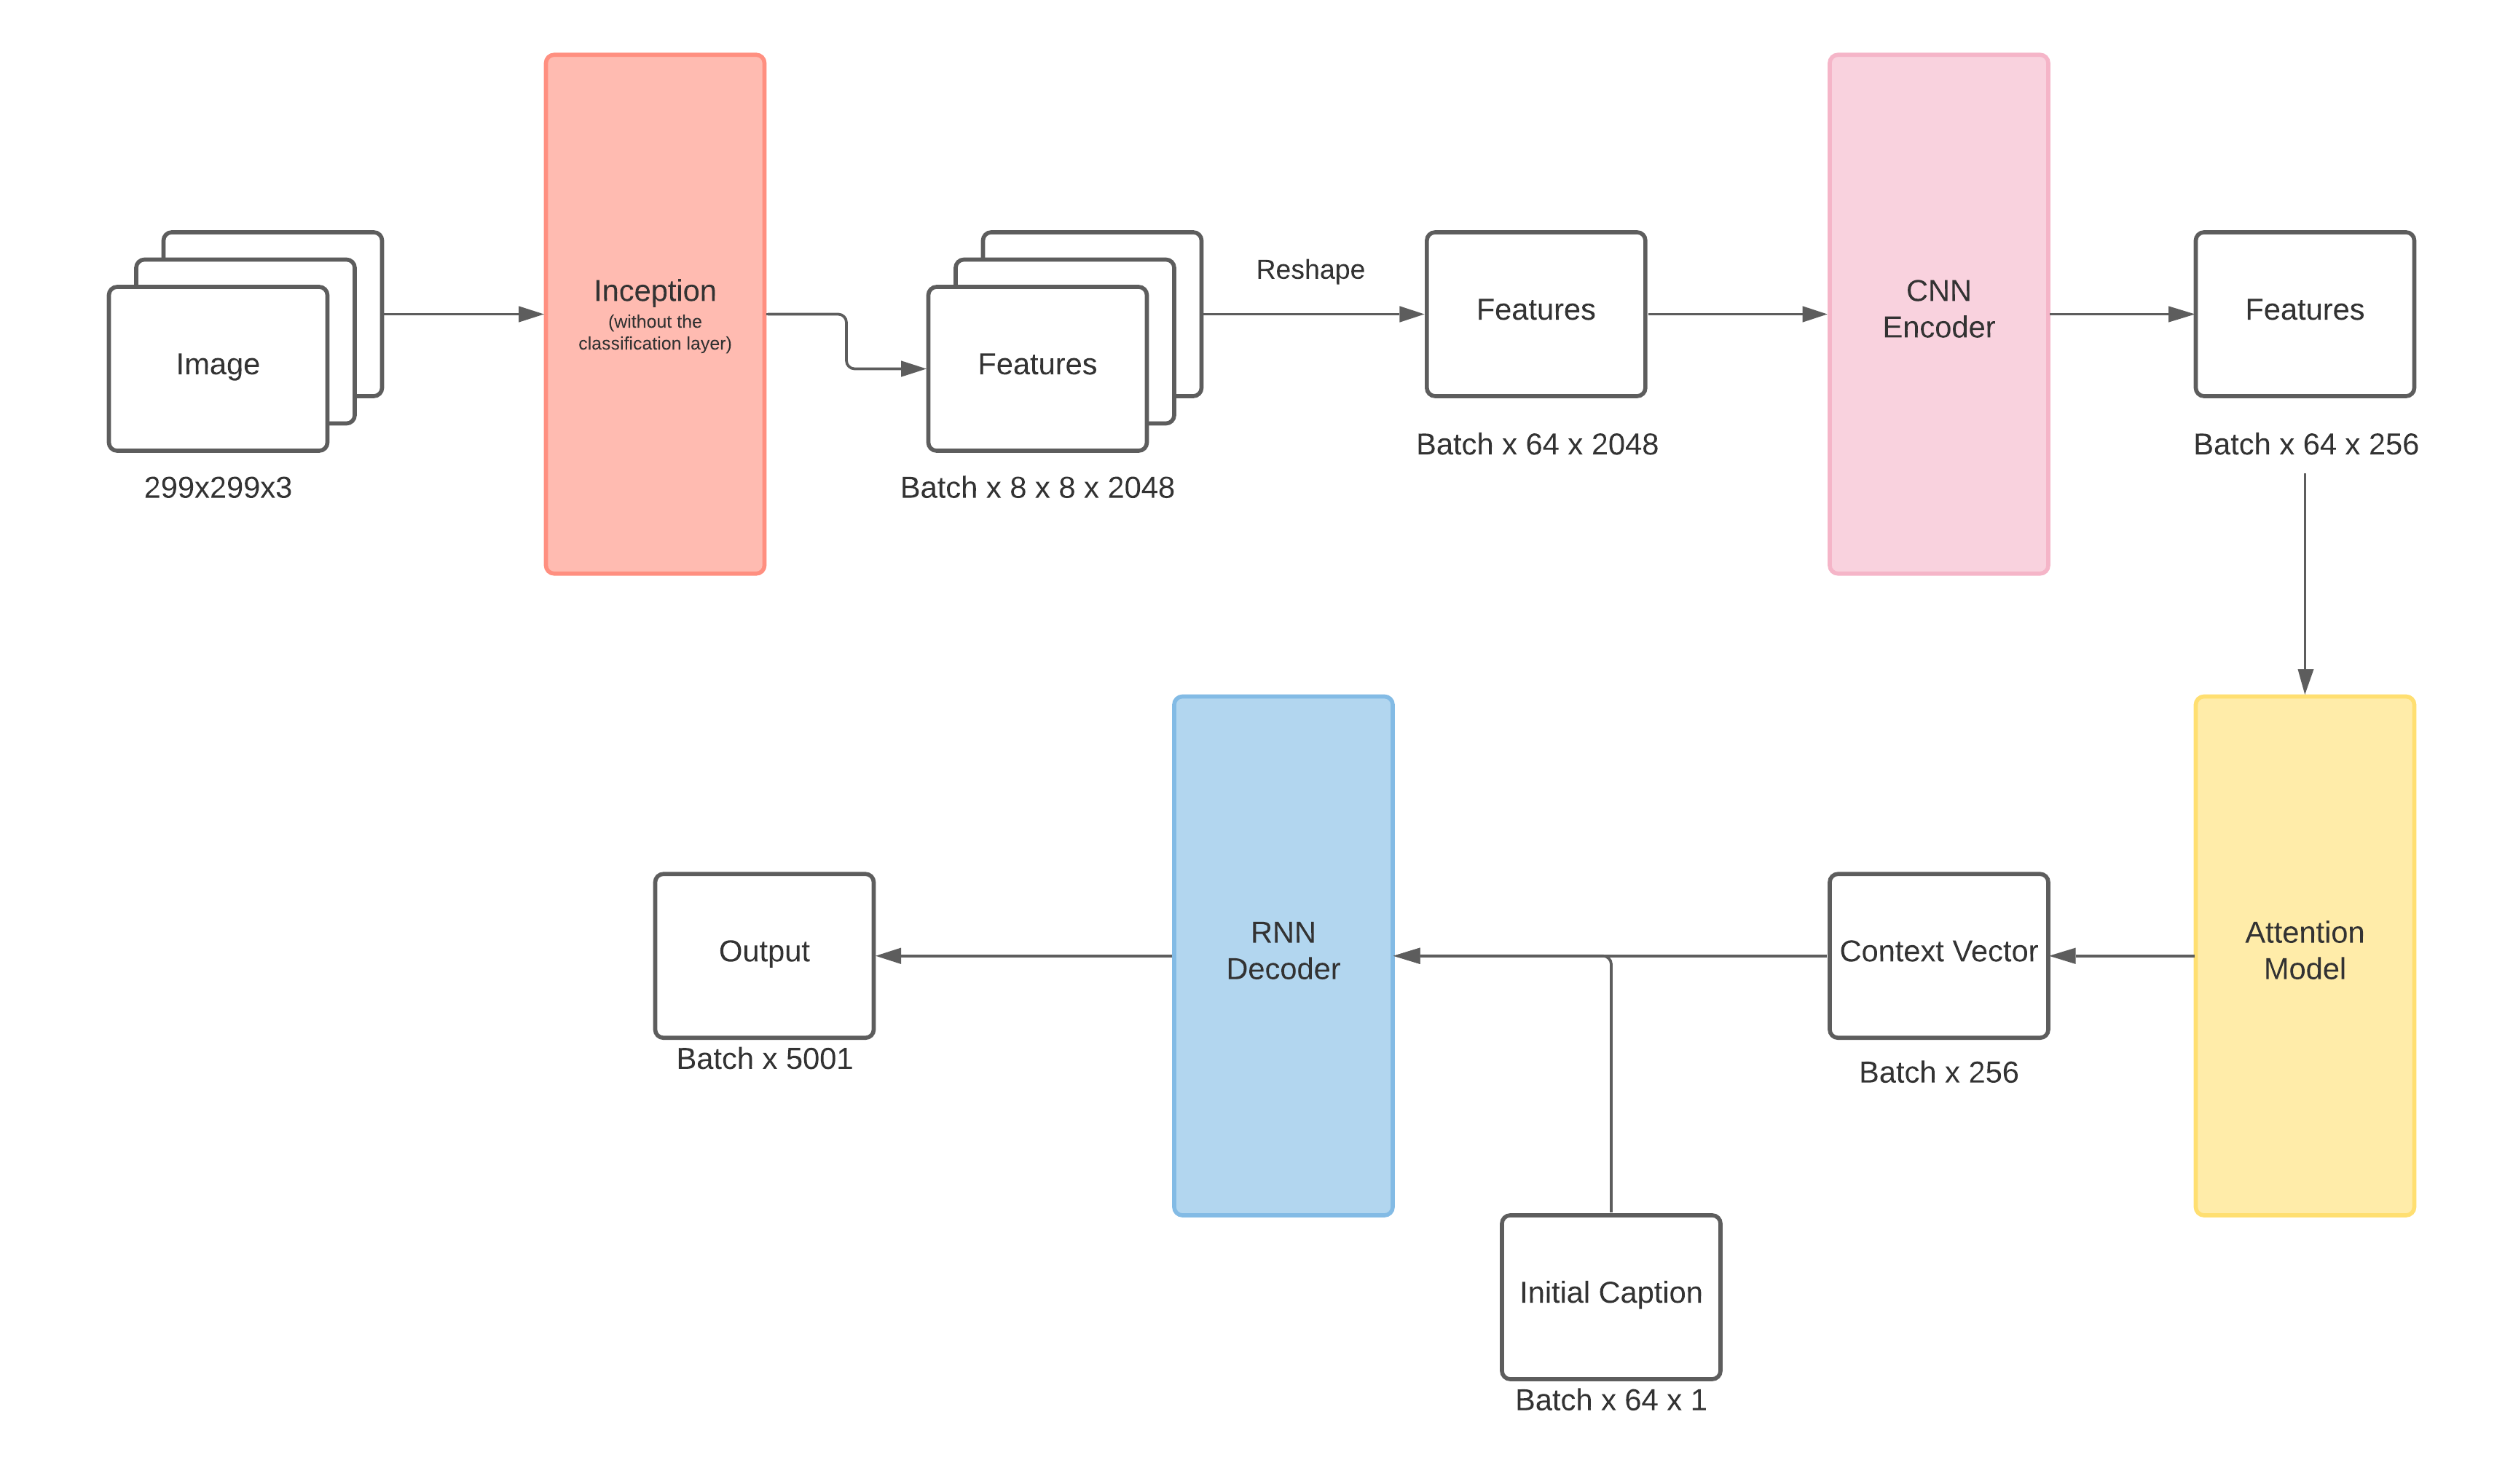

In [ ]:
# Parámetros

embedding_dim = 256                             # Tamaño de la representación de las imágenes aplanadas
units = 512                                     # Unidades de la capa de atención
vocab_size = num_words + 1                      # Tamaño del vocabulario + token para palabras desconocidas
train_num_steps = len(img_train) // BATCH_SIZE  # Número de pasos de entrenamiento por época
val_num_steps = len(img_val) // BATCH_SIZE      # Número de pasos de validation por época
test_num_steps = len(img_test) // BATCH_SIZE    # Número de pasos de test por época
features_shape = 64                             # bf = batch_features de la última imagen que se procesó. 64 = 8x8
attention_features_shape = 64                   # Inception Bacth Size

NameError: ignored

## 3.1 CNN Encoder

En este caso, la extracción de características está a cargo de Inception, adicional, se pasan por una capa densa lineal de menor dimensionalidad con el fin de reducir costos computacionales.

A continuación, un diagrama que representa la arquitectura.

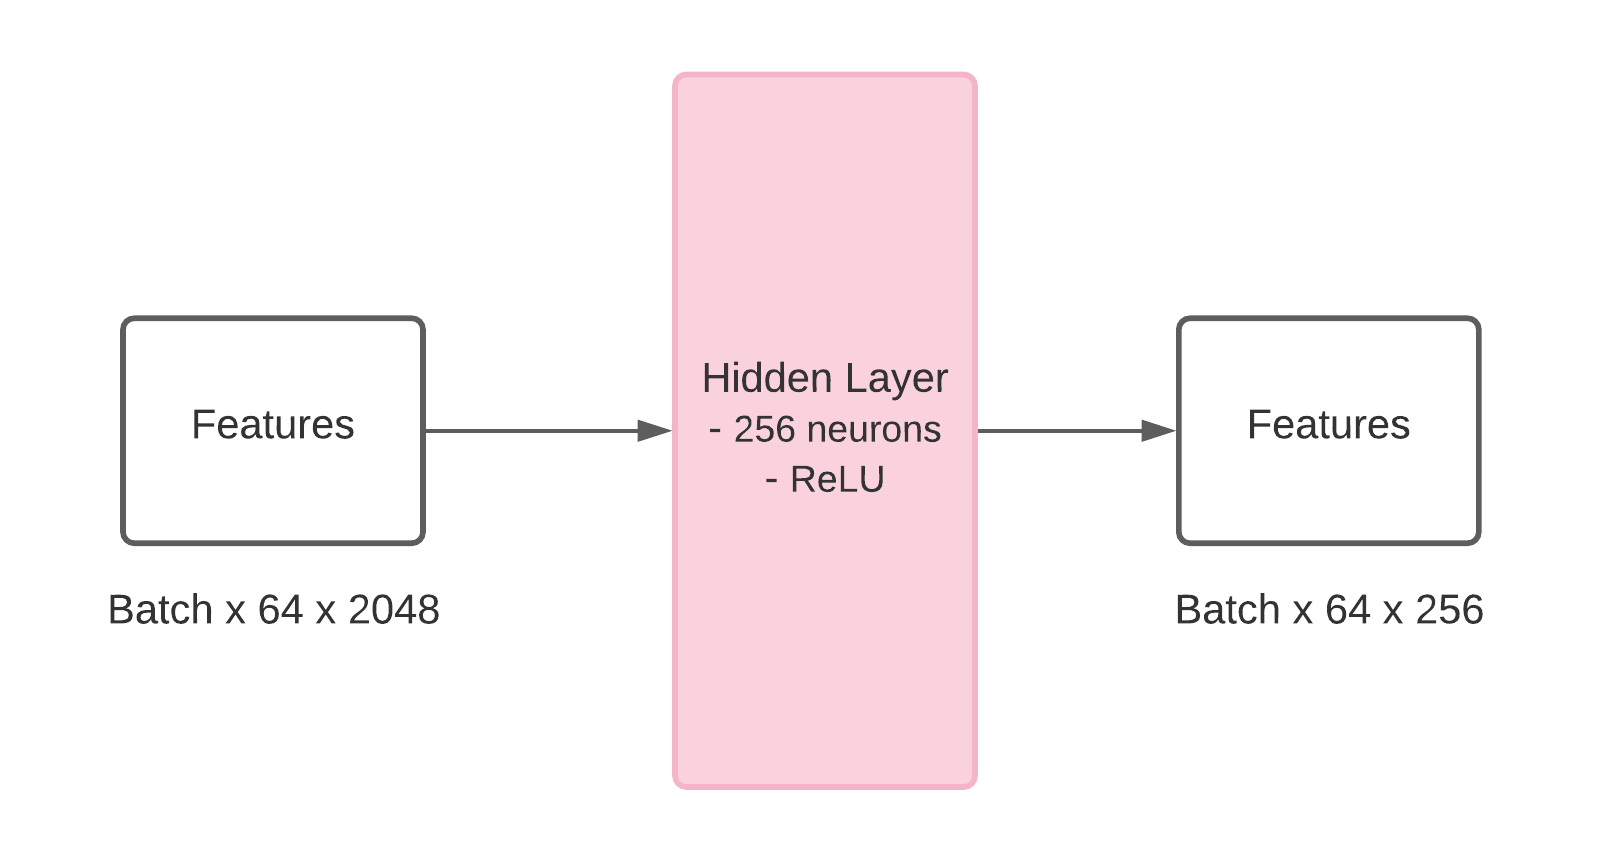

In [ ]:
class CNN_Encoder(keras.Model):
    # Pasar las features extraidas con Inception por una capa densa
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = layers.Dense(embedding_dim)
        #self.dropout = layers.Dropout(0.5)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

## 3.2 Attention Model

El Modelo de atención es el encargado de identificar las zonas/píxeles de la imagen más relevantes y a los cuales se les debe prestar mayor atención a la hora de generar la descripción/caption.

A continuación, un diagrama que representa la arquitectura.

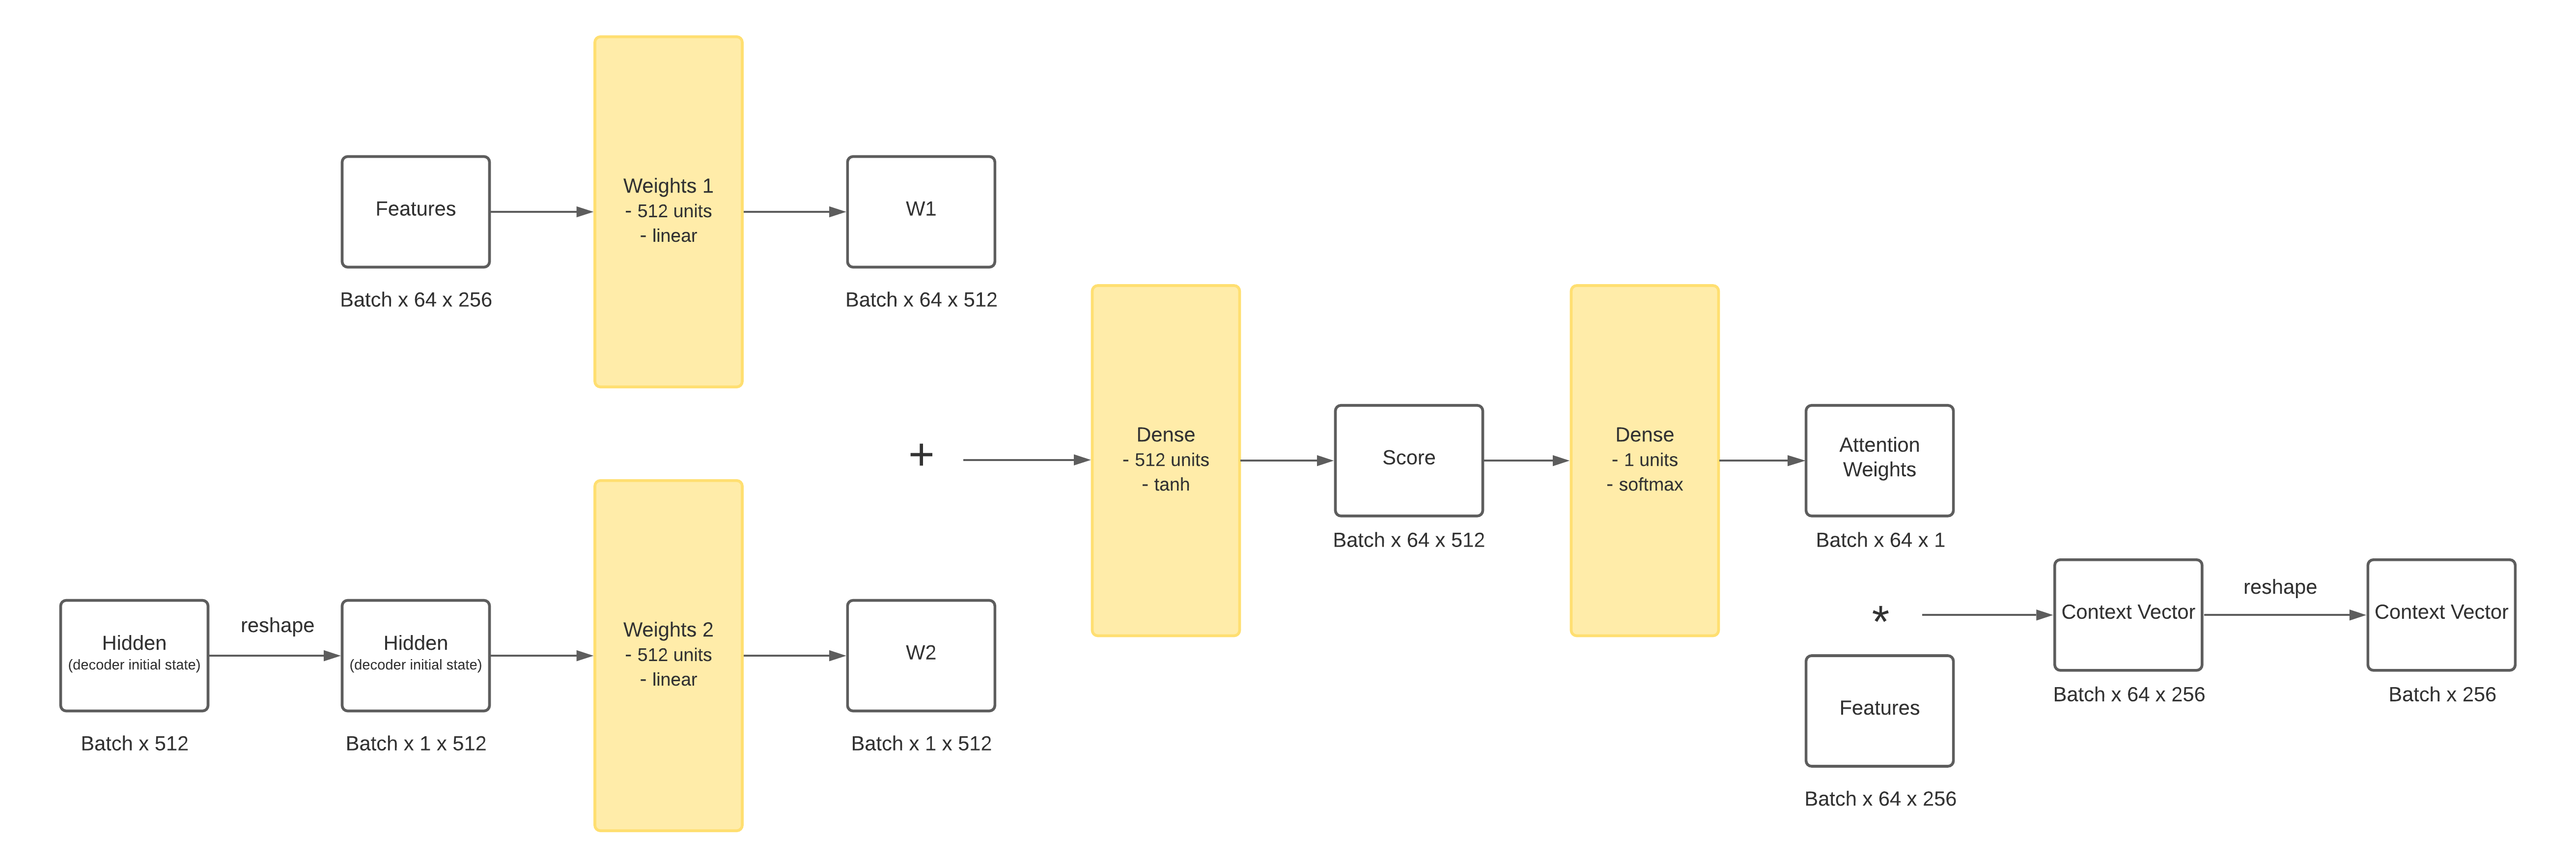

In [ ]:
class Attention_model(keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        # features shape: (batch_size, 64, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # To expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) 
        # build score funciton to shape: (batch_size, 8*8, units)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) 
        # to extract attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = keras.activations.softmax(self.V(score), axis=1) 
        #create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

## 3.3 RNN Decoder

El RNN Decoder se encarga de generar el caption a partir del vector de contexto obtenido en el Modelo de Atención, este vector se obtiene a partir de las características de la imagen extraídas con Inception.

A conitnuación, un diagrama que representa la arquitectura.

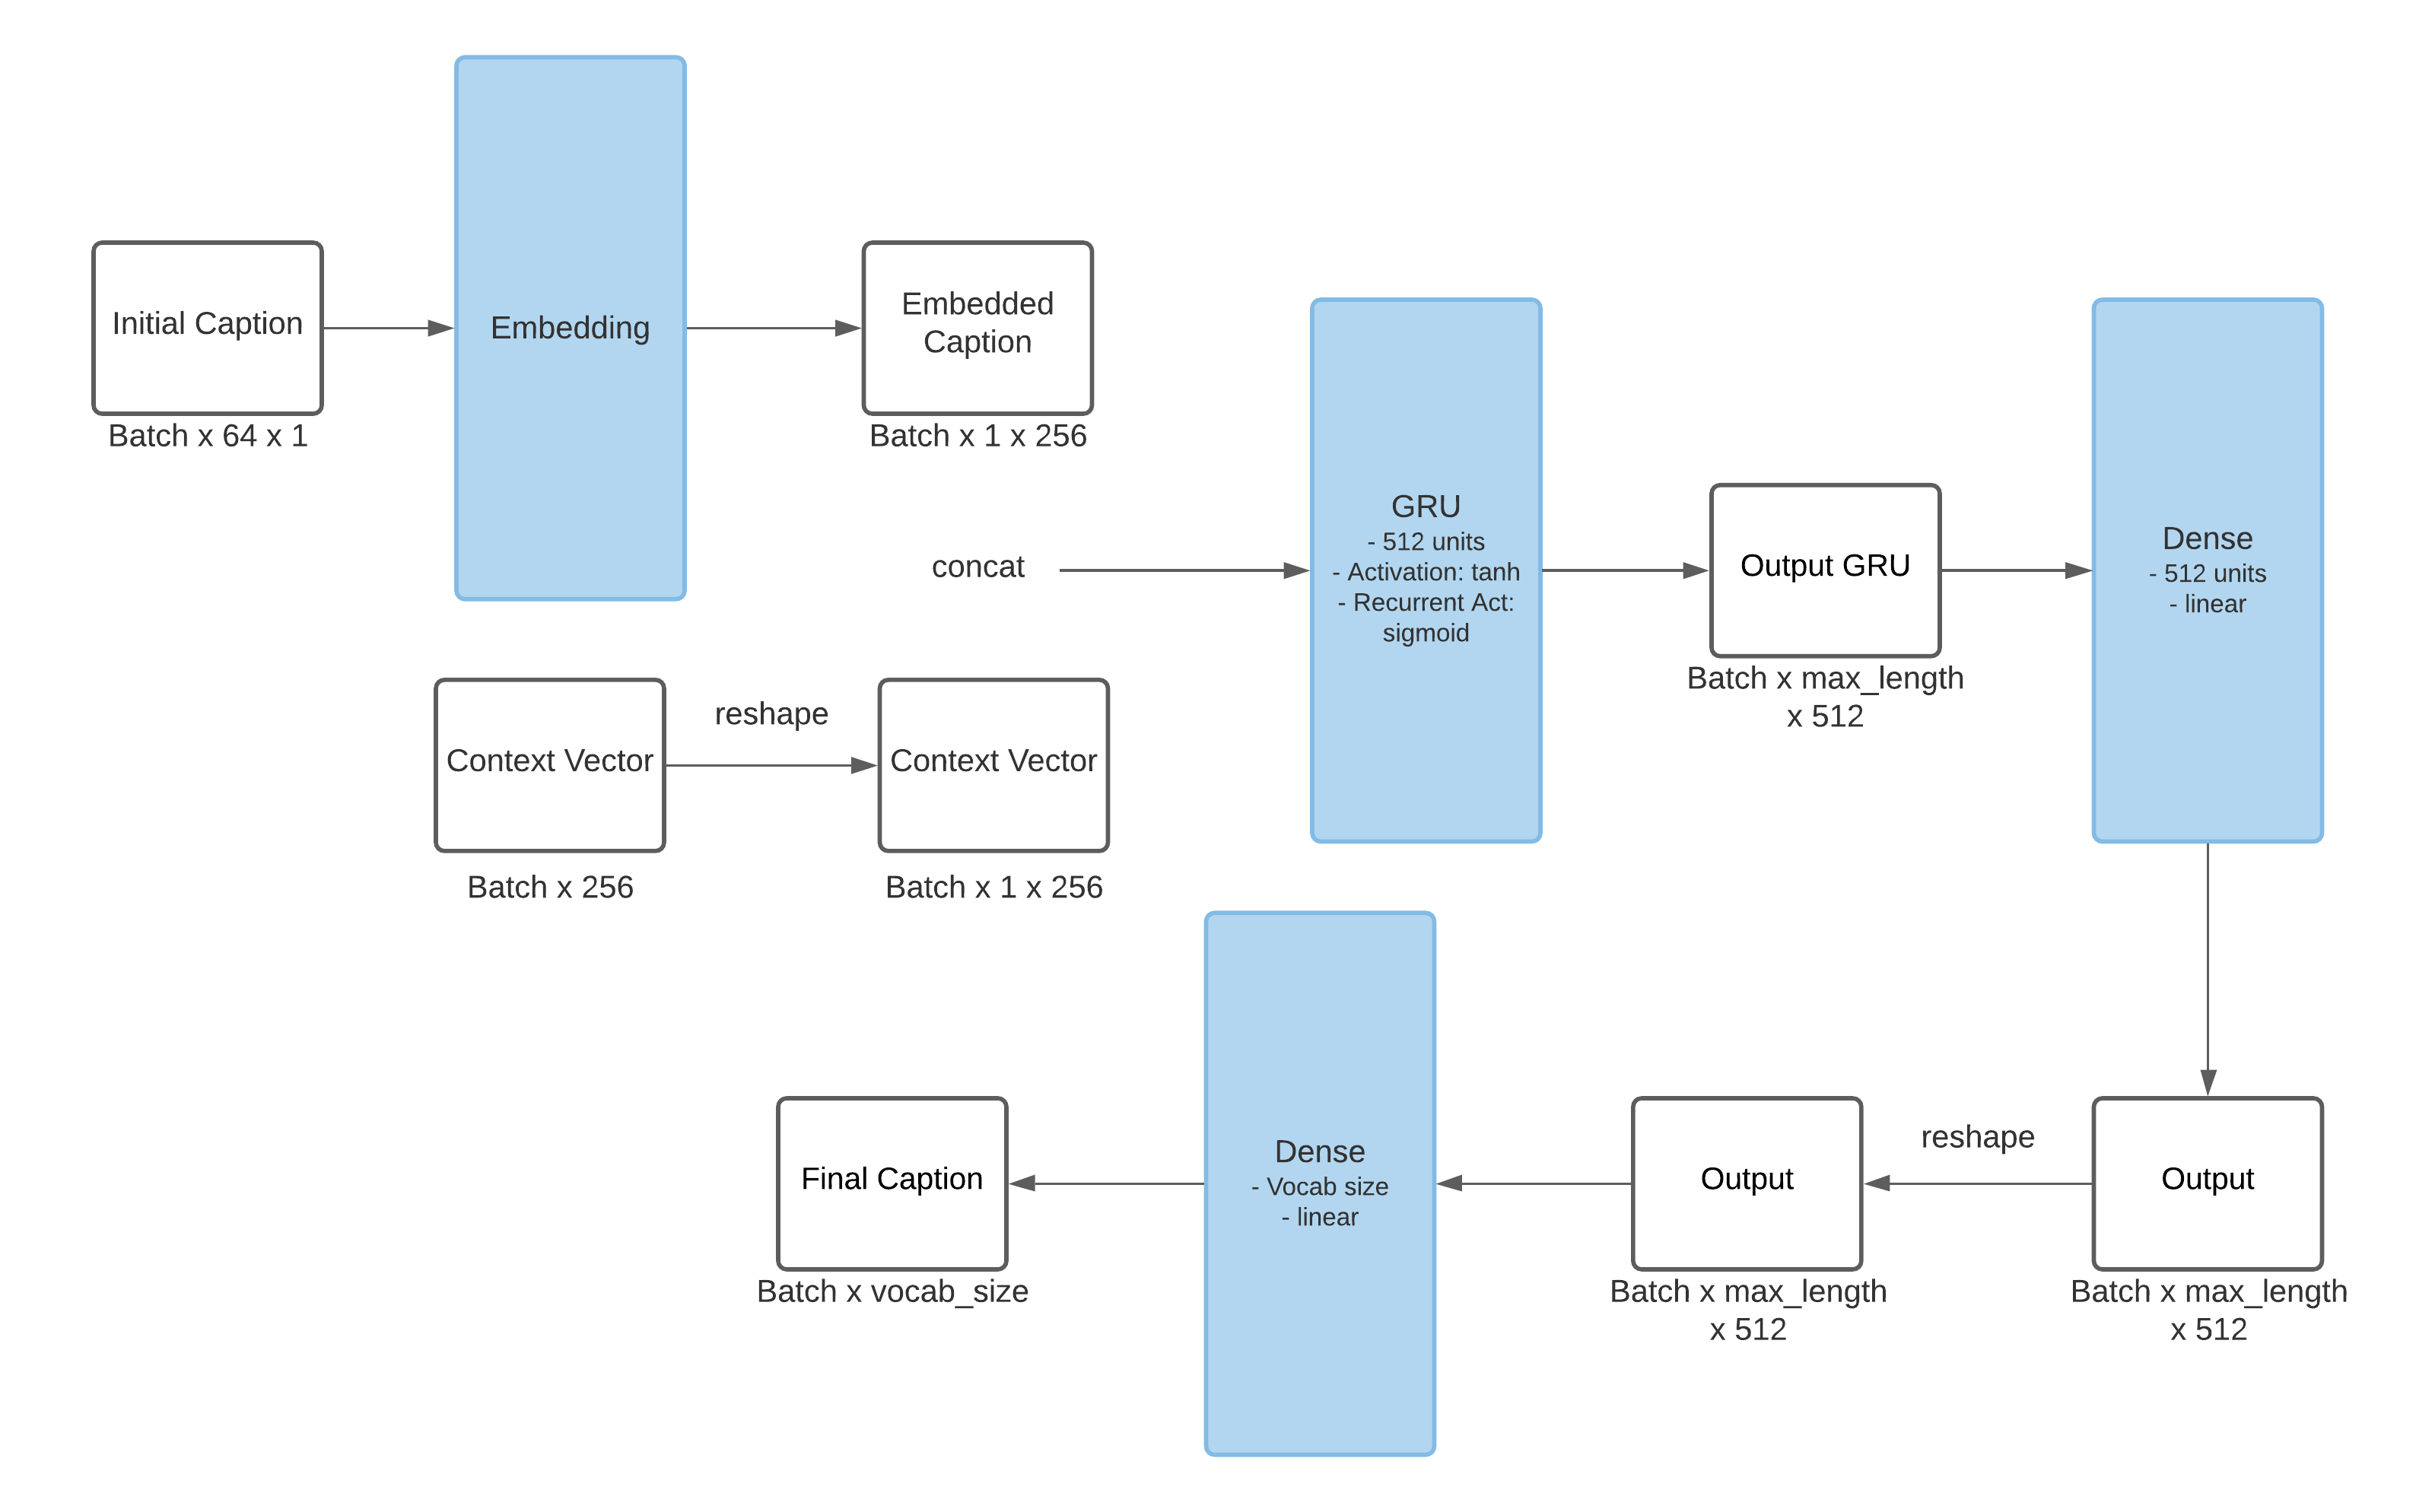

In [ ]:
class RNN_Decoder(keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units=units
        # Inicializar el Modelo de Atención con las unidades definadas en los parámetros
        self.attention = Attention_model(self.units) 
        # Construir una capa de embedding
        self.embed = layers.Embedding(vocab_size, embed_dim, mask_zero=True)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)
        #self.dropout = Dropout(0.5)
        

    def call(self,x,features, hidden):
        #create context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        
        # embed input (target caption) to shape 
        embed = self.embed(x) #shape: (batch_size, 1, embedding_dim)
    
        # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) 
        
        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output,state = self.gru(embed) # output shape : (batch_size, max_length, hidden_size)
        output = self.fc1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.fc2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
# inicializar el modelo
encoder = CNN_Encoder(embedding_dim)
attention = Attention_model(units)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch) # Aplanar las features extraidas de Inception

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0]) # El vector hidden es el estado inicial del Decoder
# Caption inicial del Decoder, es un vector de tamaño 64x1 donde cada posición es la representación numérica del token de inicio de descripción <start>
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


# Entrenamiento

Se utiliza una función de pérdida basada en `SparseCategoricalCrossentropy`, lo que va a permitir que por cada predicción del decoder (batch_size, vocab_size) se obtenga un único digito que indica la palabra del vocabulario predicha y así poder comparar con la esperada.

In [ ]:
# Set Optmizer and Loss Object
optimizer = tf.keras.optimizers.RMSprop()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):

    # equal: compara x == y elemet-by-element, returns an array with True or False for each element | logical_not: Returns the truth value of NOT x element-wise.
    mask = tf.math.logical_not(tf.math.equal(real, 0)) 
    # compare real with pred using SparseCategoricalCrossentropy
    loss_ = loss_object(real, pred)

    # cast the mask to the same type of loss
    mask = tf.cast(mask, dtype=loss_.dtype)
    # multiply by the mask, that indicates wich are the elements of the loss that matters
    loss_ *= mask

    # Computes the mean of elements across dimensions of a tensor.
    return tf.reduce_mean(loss_)

In [ ]:
# Create a checkpoint manager so we can restore the best state of the model later
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
# Starts where the latest checkpoint left
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
# train function - teacher forcing
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0]) # decoder initial state
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) # initial caption
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor) # get reduce features by decoder

        for i in range(1, target.shape[1]): # for each word in the target caption
            predictions, hidden, _ = decoder(dec_input, features, hidden) # get the predicctions
            loss += loss_function(target[:, i], predictions) # compute the loss
            dec_input = tf.expand_dims(target[:, i], 1) # update the input to the decoder
        
    avg_loss = (loss / int(target.shape[1])) # compute average loss

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables # get the trainable variables of the model
    gradients = tape.gradient(loss, trainable_variables) # calculate the gradients
    optimizer.apply_gradients(zip(gradients, trainable_variables)) # update the weights base on the gradients
       
    return loss, avg_loss

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0]) # decoder initial state
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) # initial caption

    features = encoder(img_tensor) # get reduce features by decoder

    for i in range(1, target.shape[1]): # for each word in the target caption
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the predicctions
        loss += loss_function(target[:, i], predictions) # compute the loss

        predicted_id =  tf.argmax(predictions,1) # get the id of the predicted word
        dec_input = tf.expand_dims(predicted_id, 1) # update the input to the decoder
        
    total_loss = (loss / int(target.shape[1])) # compute total loss

    return loss, total_loss

In [ ]:
# test loss function
def test_loss_cal(test_dataset):
    total_loss_test = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
        avg_test_loss=total_loss_test / test_num_steps
    
    return avg_test_loss

In [ ]:
# model training
loss_plot = []
#test_loss_plot = []
val_loss_plot = []
EPOCHS = 20

best_val_loss=100
#best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)  
    #Validation se comporta como test  
    val_loss = test_loss_cal(val_dataset)
    val_loss_plot.append(val_loss)
    #test_loss = test_loss_cal(test_dataset)
    #test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & val loss is {:.3f}'.format(epoch+1,avg_train_loss,val_loss))
    
    #print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if val_loss < best_val_loss:
    #if test_loss < best_test_loss:
        print('Val loss has been reduced from %.3f to %.3f' % (best_val_loss, val_loss))
        #print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_val_loss = val_loss
        #best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/20 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.410, & val loss is 2.149
Time taken for 1 epoch 339.51943278312683 sec

Val loss has been reduced from 100.000 to 2.149


  5%|▌         | 1/20 [05:40<1:47:43, 340.19s/it]

For epoch: 2, the train loss is 1.159, & val loss is 2.111
Time taken for 1 epoch 204.1694655418396 sec

Val loss has been reduced from 2.149 to 2.111


 10%|█         | 2/20 [09:04<1:18:09, 260.54s/it]

For epoch: 3, the train loss is 1.081, & val loss is 2.032
Time taken for 1 epoch 233.08700966835022 sec

Val loss has been reduced from 2.111 to 2.032


 20%|██        | 4/20 [16:19<1:01:14, 229.65s/it]

For epoch: 4, the train loss is 1.029, & val loss is 2.057
Time taken for 1 epoch 201.05664134025574 sec

For epoch: 5, the train loss is 0.984, & val loss is 1.973
Time taken for 1 epoch 234.16662001609802 sec

Val loss has been reduced from 2.032 to 1.973


 30%|███       | 6/20 [24:08<54:12, 232.31s/it]

For epoch: 6, the train loss is 0.945, & val loss is 2.032
Time taken for 1 epoch 233.82346081733704 sec



 35%|███▌      | 7/20 [28:01<50:21, 232.45s/it]

For epoch: 7, the train loss is 0.908, & val loss is 2.054
Time taken for 1 epoch 232.67077326774597 sec



 40%|████      | 8/20 [31:22<44:29, 222.46s/it]

For epoch: 8, the train loss is 0.874, & val loss is 2.131
Time taken for 1 epoch 201.04954290390015 sec



 45%|████▌     | 9/20 [34:42<39:30, 215.53s/it]

For epoch: 9, the train loss is 0.839, & val loss is 2.123
Time taken for 1 epoch 200.22236323356628 sec



 50%|█████     | 10/20 [38:03<35:08, 210.89s/it]

For epoch: 10, the train loss is 0.807, & val loss is 2.244
Time taken for 1 epoch 200.46228885650635 sec



 55%|█████▌    | 11/20 [41:23<31:09, 207.75s/it]

For epoch: 11, the train loss is 0.776, & val loss is 2.305
Time taken for 1 epoch 200.6022219657898 sec



 60%|██████    | 12/20 [44:43<27:23, 205.43s/it]

For epoch: 12, the train loss is 0.746, & val loss is 2.264
Time taken for 1 epoch 200.05674242973328 sec



 65%|██████▌   | 13/20 [48:04<23:47, 203.88s/it]

For epoch: 13, the train loss is 0.717, & val loss is 2.311
Time taken for 1 epoch 200.27388882637024 sec



 70%|███████   | 14/20 [51:25<20:19, 203.24s/it]

For epoch: 14, the train loss is 0.690, & val loss is 2.396
Time taken for 1 epoch 201.73912262916565 sec



 75%|███████▌  | 15/20 [55:18<17:40, 212.18s/it]

For epoch: 15, the train loss is 0.663, & val loss is 2.449
Time taken for 1 epoch 232.84407711029053 sec



 80%|████████  | 16/20 [58:41<13:57, 209.35s/it]

For epoch: 16, the train loss is 0.640, & val loss is 2.518
Time taken for 1 epoch 202.7529423236847 sec



 85%|████████▌ | 17/20 [1:02:04<10:22, 207.46s/it]

For epoch: 17, the train loss is 0.617, & val loss is 2.511
Time taken for 1 epoch 203.01513409614563 sec



 90%|█████████ | 18/20 [1:05:27<06:51, 205.94s/it]

For epoch: 18, the train loss is 0.596, & val loss is 2.620
Time taken for 1 epoch 202.34633708000183 sec



 95%|█████████▌| 19/20 [1:09:19<03:33, 213.85s/it]

For epoch: 19, the train loss is 0.580, & val loss is 2.660
Time taken for 1 epoch 232.2304208278656 sec



100%|██████████| 20/20 [1:12:41<00:00, 218.08s/it]

For epoch: 20, the train loss is 0.567, & val loss is 2.604
Time taken for 1 epoch 202.28092861175537 sec



A continuación, una gráfica con la pérdida duarante entranemitno y validación del modelo, recordemos que se almacenan los pesos del modelo con menor pérdida sobre validación. La línea azul representa entrenamiento y la naranja validación.

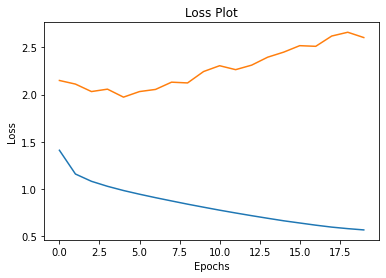

In [ ]:
plt.plot(loss_plot)
plt.plot(val_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Evalaución del modelo
1. Se difine la función de eavulación del modelo usando Greedy Search.

2. Se calcula el BLEU score sobre validación y test.

3. Se visualizan las predicciones de algunas imágenes de test con su respectivos resultados de la capa de atención.


## 3.1 Cargar el mejor modelo

In [ ]:
embedding_dim = 256                             # Tamaño de la representación de las imágenes aplanadas
units = 512                                     # Unidades de la capa de atención
vocab_size = num_words + 1                      # Tamaño del vocabulario + token para palabras desconocidas
features_shape = 64                             # bf = batch_features de la última imagen que se procesó. 64 = 8x8
attention_features_shape = 64                   # Inception Bacth Size

In [ ]:
encoder = CNN_Encoder(embedding_dim)
attention = Attention_model(units)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)

ckpt_path = tf.train.latest_checkpoint(checkpoint_path)
ckpt.restore(ckpt_path)

## 3.2 Greedy search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)
    #process the input image to desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0) 
    
    # Extract features using our feature extraction model
    img_tensor_val = base_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [ ]:
def plot_attmap(image, result, attention_plot):

    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# to filter unwanted tokens 
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

## 3.3 Calcular BLEU Score

In [ ]:
from tqdm import tqdm

In [ ]:
def calculate_belu(img_data, cap_data):
    real_captions= []
    candidates = []

    for img, cap in tqdm(zip(img_data, cap_data), desc="Calculating BLEU"):
        # Get the text of the real caption
        real_caption = ' '.join([tokenizer.index_word[i] for i in cap if i not in [0]])
        real_caption=filt_text(real_caption)


        # Get the text of the predicted caption
        result, attention_plot,pred_test = evaluate(img)
 
        pred_caption=' '.join(result).rsplit(' ', 1)[0]

        # Add to the corpus to calculate BELU
        real_captions.append(real_caption.split())
        candidates.append(pred_caption.split())

    print('BELU score 1-gram: %f' % corpus_bleu(real_captions, candidates, weights=(1, 0, 0, 0)))
    print('BELU score 2-gram: %f' % corpus_bleu(real_captions, candidates, weights=(.5, .5, 0, 0)))
    print('BELU score 3-gram: %f' % corpus_bleu(real_captions, candidates, weights=(.33, .33, .33, 0)))
    print('BELU score 4-gram: %f' % corpus_bleu(real_captions, candidates, weights=(.25, .25,.25, .25)))

In [ ]:
print('-'*20, 'Validación', '-'*20)
calculate_belu(img_val, cap_val)

print('-'*20, 'Test', '-'*20)
calculate_belu(img_test, cap_test)

-------------------- Validación --------------------


Calculating BLEU: 8091it [1:34:09,  1.43it/s]
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BELU score 1-gram: 0.067776
BELU score 2-gram: 0.260339
BELU score 3-gram: 0.411392
BELU score 4-gram: 0.510234
-------------------- Test --------------------


Calculating BLEU: 8091it [1:01:59,  2.18it/s]


BELU score 1-gram: 0.068009
BELU score 2-gram: 0.260785
BELU score 3-gram: 0.411857
BELU score 4-gram: 0.510671


# Predicción

In [ ]:
# function for prediction and text to speech conversion
# for (batch, (img_tensor, target)) in enumerate(test_dataset):
def pred_speech():
    # take a random image

    ### TODO: modificar test img seleccion de imagen segun estructura actual
    rid = np.random.randint(0, len(x))
    test_image = img_test[rid]
    
    # print original image
    print('Original image:')
    plt.imshow(mpimg.imread(test_image),interpolation='nearest',aspect='auto')
    Image.open(test_image)
    plt.title('Selected Image for testing:')
    plt.grid(None)
    print("#"*100) 
    
    # print the real caption 
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    real_caption=filt_text(real_caption)
    print ('Real Caption:', real_caption)
    print("#"*100)
    
    #print predicted caption
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    print ('Prediction Caption:', pred_caption)
    print("#"*100)
    
    # to print Belu score    
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    
    # Belu score for different weights
    print('BELU score 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
    print('BELU score 2-gram: %f' % sentence_bleu(reference, candidate, weights=(.5, .5, 0, 0)))
    print('BELU score 3-gram: %f' % sentence_bleu(reference, candidate, weights=(.33, .33, .33, 0)))
    print('BELU score 4-gram: %f' % sentence_bleu(reference, candidate, weights=(.25, .25,.25, .25)))
    print("#"*100)
    
    # to plot Captions generated by Attention model along with images 
    print('Captions generated by Attention model:')
    plot_attmap(test_image, result, attention_plot)
    print("#"*100)

    # to convert text to speech
    print('Audio for the predicted caption:')                      
    language = 'en'
    txt_spch = gTTS(text=pred_caption, lang=language, slow=False)
    txt_spch.save("text_to_speech.mp3")                                              

Original image:
####################################################################################################
Real Caption: <start>person in neon green jacket and hat standing on sidewalk while people walk by<end>
####################################################################################################
Prediction Caption: people are walking down a busy street
####################################################################################################
BELU score 1-gram: 0.052554
BELU score 2-gram: 0.139045
BELU score 3-gram: 0.193563
BELU score 4-gram: 0.226168
####################################################################################################
Captions generated by Attention model:


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


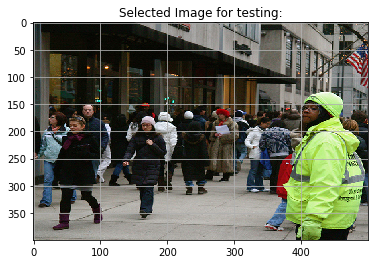

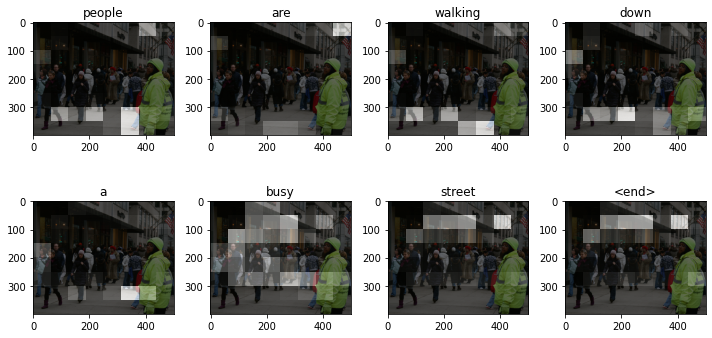

####################################################################################################
Audio for the predicted caption:


In [ ]:
#test 1
pred_speech()
Audio("text_to_speech.mp3", autoplay=True)

Original image:
####################################################################################################
Real Caption: two women in fluffy skirts dancing to music played by men
####################################################################################################
Prediction Caption: people walk down a street
####################################################################################################
BELU score 1-gram: 0.000000
BELU score 2-gram: 0.000000
BELU score 3-gram: 0.000000
BELU score 4-gram: 0.000000
####################################################################################################
Captions generated by Attention model:


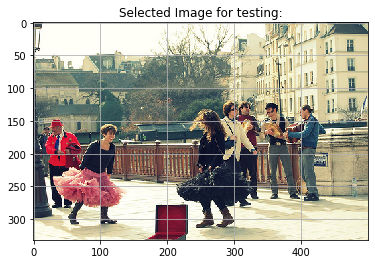

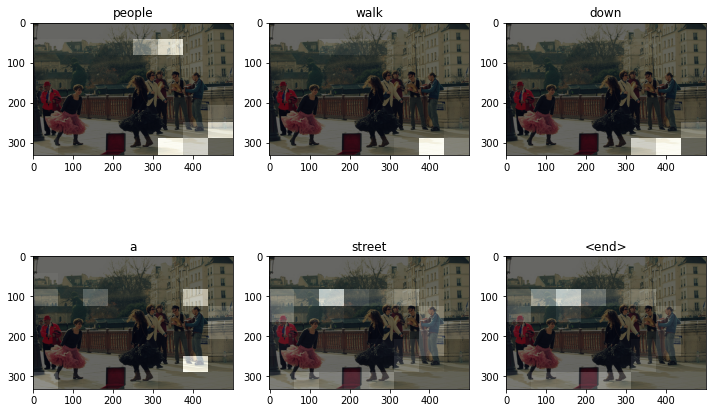

####################################################################################################
Audio for the predicted caption:


In [ ]:
#test 2
pred_speech()
Audio("text_to_speech.mp3", autoplay=True)

Original image:
####################################################################################################
Real Caption: <start>a toddler is making a splash inside a blue paddling pool
####################################################################################################
Prediction Caption: boy is splashing in a pool
####################################################################################################
BELU score 1-gram: 0.217299
BELU score 2-gram: 0.307307
BELU score 3-gram: 0.345739
BELU score 4-gram: 0.365452
####################################################################################################
Captions generated by Attention model:


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


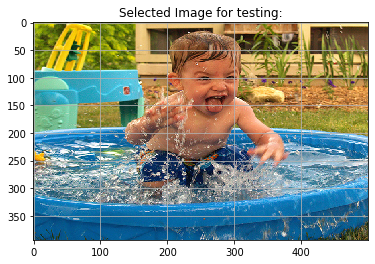

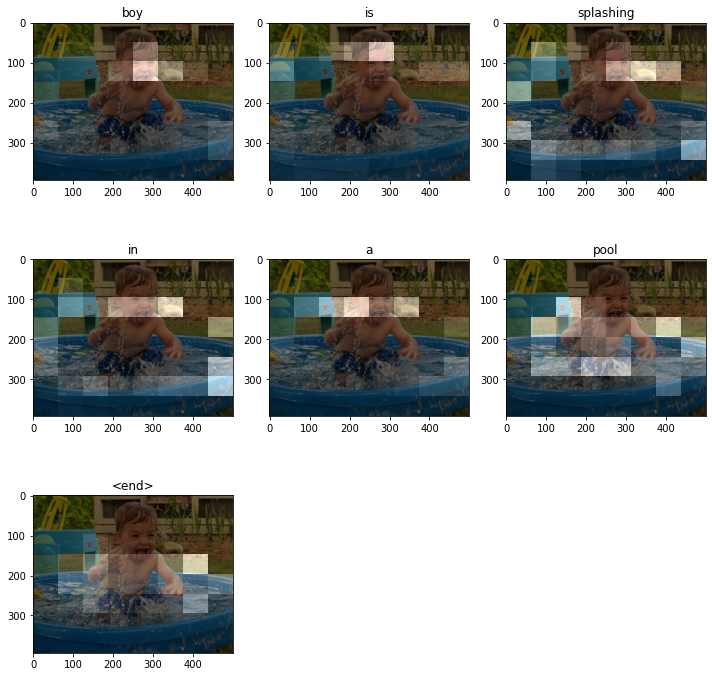

####################################################################################################
Audio for the predicted caption:


In [ ]:
#test 3
pred_speech()
Audio("text_to_speech.mp3", autoplay=True)

# Despliegue

In [ ]:
!pip install gradio

     |████████████████████████████████| 979 kB 3.8 MB/s 
     |████████████████████████████████| 2.0 MB 26.4 MB/s 
     |████████████████████████████████| 206 kB 53.6 MB/s 
     |████████████████████████████████| 3.6 MB 25.4 MB/s 
     |████████████████████████████████| 961 kB 41.4 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=5123708bf9f6cb2311e8b64415ac0c073812a18f972574ea7bc00a4fbef1bcb3
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=230954bb49a9387da33a61b41a5bb140073646265c0c916cb245fd53671cc493
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [ ]:
import gradio as gr

def predict(image):

    # Important: Before this cell is necessary to load Inception, Init the model and Load the best model
    # Prediction
    result, attention_plot,pred_test = evaluate(image.name)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    
    # Text to Speech
    language = 'en'
    txt_spch = gTTS(text=pred_caption, lang=language, slow=False)
    txt_spch.save("text_to_speech.mp3")

    return image.name, pred_caption, "text_to_speech.mp3"
  

iface = gr.Interface(fn=predict, inputs="file", outputs=["image", "text", "audio"])
iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://49399.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app
